In [1]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp2d
from matplotlib.animation import FuncAnimation, PillowWriter

from nv_files.Field_Generator import omega0_samples,omega0_samples_torch
from nv_files.FEM_Solver import VorticitySolver
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D



import torch
from ml_collections import ConfigDict
from scipy.interpolate import griddata

from nv_files.data_generator import solve_poisson_fft,compute_velocity,UniformSampler
from nv_files.NavierStokes import NavierStokes
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# DeepGaLa

In [3]:
from nv_files.train_nvs import ic_vort_samples,data_vor_set_preparing
from Base.lla import dgala


def get_deepgalerkin_config():
    config = ConfigDict()

    # Training settings
    config.seed = 180

    config.chunks = 16
    config.points_per_chunk = 250
    config.batch_ic = 8500 
 

    # For deep Galerkin
    config.dim_initial_condition = 128
    config.tau = np.sqrt(2)
    config.d = 5

    config.time_domain = 2
    config.NKL =  1
    config.samples_size_initial = 1000
    
    return config

config = get_deepgalerkin_config()

initial_points,w0,theta = ic_vort_samples(config)

batch_size_interior = config.chunks*config.points_per_chunk

dom = torch.tensor([[0, 2 * torch.pi], [0, 2 * torch.pi],[0,config.time_domain]]).to(device)

samples_interior = iter(UniformSampler(dom, batch_size_interior))

batch = next(samples_interior).to(device)

sorted_batch,initial_points_,initial_condition = data_vor_set_preparing(config,batch, 
                                                    initial_points,w0,theta,batch_size_interior,0)

In [4]:
data_trainig = {"data_fit": {"pde":sorted_batch, "initial_conditions":(initial_condition,initial_points_)}, 
                "class_method": {"pde": ["nv_pde"], "initial_conditions":["w"]},
                "outputs": {"pde": ["nvs", "cond"], "initial_conditions": ["w0"]}}

In [ ]:
MDNN_dg = torch.load(f"./models/vorticity_MDNN_dg_1.pth")
MDNN_dg.eval()

llp = dgala(MDNN_dg)


In [ ]:
llp.fit(data_trainig)

In [7]:
from Base.utilities import clear_hooks

clear_hooks(llp)
torch.save(llp, f"./models/nvs_lla.pth")

Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

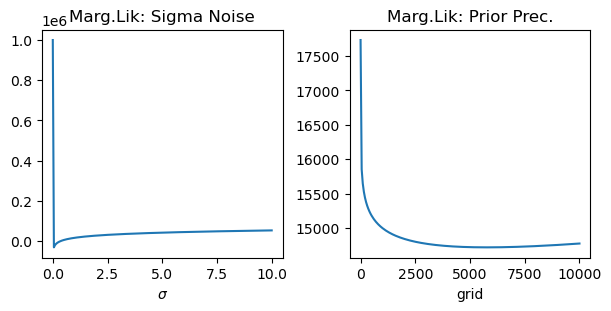

In [15]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(f"./models/nvs_lla.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

sn = torch.linspace(10, 0.0001, 200)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,log_marg_lh)
axs[0].set_xlabel("$\sigma$")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(f"./models/nvs_lla.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

priorpre = torch.linspace(10000, 0.1, 200)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
axs[1].set_xlabel("grid")
axs[1].set_title("Marg.Lik: Prior Prec.")

In [32]:
llp = torch.load(f"./models/nvs_lla.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.optimize_marginal_likelihood(error_tolerance=1e-3, max_iter=1000)
print(llp.sigma_noise,llp.prior_precision)

Iteration 100, Error: 0.01001, neg_marglik: 1001.44946
Iteration 200, Error: 0.01001, neg_marglik: -15194.86523
Iteration 300, Error: 0.01000, neg_marglik: -31384.62891
Iteration 400, Error: 0.00996, neg_marglik: -47530.86328
Iteration 500, Error: 0.00981, neg_marglik: -63365.63672
Iteration 600, Error: 0.00901, neg_marglik: -77174.66406
Iteration 700, Error: 0.00625, neg_marglik: -83620.33594
Iteration 800, Error: 0.00367, neg_marglik: -84232.03906
Iteration 900, Error: 0.00212, neg_marglik: -84319.61719
tensor(0.0012) tensor([4930.8813])


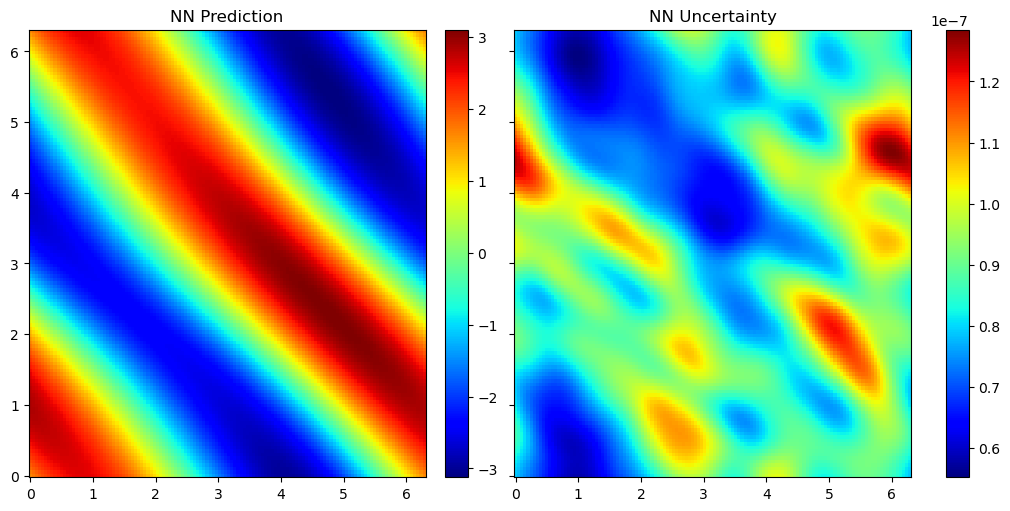

In [33]:
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),2*torch.ones_like(X.reshape(-1,1)))).float()

th1 = theta[:,:,0].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)

dataset1 = torch.cat((data_test, th1), dim=1)  # Shape (16000, 103)

surg_mu, surg_sigma = llp(dataset1)

surg_mu = surg_mu[:,0].view(-1, 1).detach().numpy()

surg_sigma = surg_sigma[:, 0].view(-1, 1).detach().numpy()

pred_mu = griddata((X.reshape(-1), Y.reshape(-1)), surg_mu.flatten(),(X, Y), method='cubic')
pred_sigma = griddata((X.reshape(-1), Y.reshape(-1)), surg_sigma.flatten(),(X, Y), method='cubic')


fig, axs = plt.subplots(1,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)

pcm1 = axs[0].pcolormesh(X, Y, pred_mu, cmap='jet')
axs[0].set_title("NN Prediction")
plt.colorbar(pcm1)

pcm = axs[1].pcolormesh(X, Y, pred_sigma, cmap='jet')
axs[1].set_title("NN Uncertainty")
plt.colorbar(pcm)